# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [Tensorflow](https://www.tensorflow.org) — an open-source software library for Machine Intelligence.
 
In this assignment, we use Tensorflow 1.15.0. You can install it with pip:

    !pip install tensorflow==1.15.0
     
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 
If you have never worked with Tensorflow, you would probably need to read some tutorials during your work on this assignment, e.g. [this one](https://www.tensorflow.org/tutorials/recurrent) could be a good starting point. 

### Data

The following cell will download all data required for this assignment into the folder `week2/data`.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week2()

import sys
sys.path.append("..")
from common.download_utils import download_week2_resources

download_week2_resources()

  0%|          | 0.00/850k [00:00<?, ?B/s]

  0%|          | 0.00/104k [00:00<?, ?B/s]

  0%|          | 0.00/107k [00:00<?, ?B/s]

In [44]:
import gc

### Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [2]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token

            if token.startswith('@'):
                token = '<USR>'
            if token.startswith('http://') or token.startswith('https://'):
                token = '<URL>'
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [3]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [4]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

In [46]:
import nltk
from collections import defaultdict

[nltk_data] Downloading package wordnet to /home/ivan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [319]:
words_counts = dict()

for el in train_tokens + validation_tokens:
    for el2 in el:
        new_el2 = el2
        words_counts[new_el2] = words_counts.get(new_el2, 0) + 1

(0.0, 4.0)

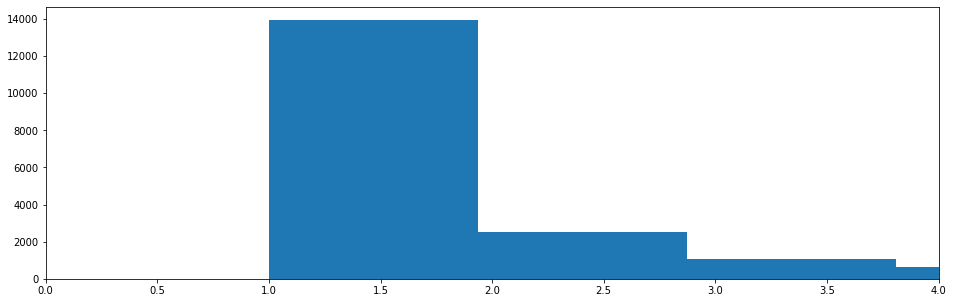

In [320]:
plt.figure(figsize=(16, 5))
plt.hist(list(words_counts.values()), bins=4000)
plt.xlim(0, 4)

In [321]:
len(set(words_counts.keys()))

20503

In [323]:
def build_dict(tokens_or_tags, special_tokens, is_tokens=False):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
    # Create mappings from tokens (or tags) to indices and vice versa.
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).
    idx2tok += special_tokens
    i = -1
    for i, token in enumerate(special_tokens):
        tok2idx[token] = i
    for sentence in tokens_or_tags:
        for el in sentence:
            if el in tok2idx:
                continue
            if is_tokens:
                if words_counts[el] != 1:
                    i += 1
                    idx2tok.append(el)
                    tok2idx[el] = i
            else:
                i += 1
                idx2tok.append(el)
                tok2idx[el] = i 
                    

    
    return tok2idx, idx2tok

After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [324]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens, is_tokens=True)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [325]:
assert max(token2idx.values()) + 1 == len(idx2token)

In [328]:
print(len(idx2token))

6553


The next additional functions will help you to create the mapping between tokens and ids for a sentence. 

In [326]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

### Generate batches

Neural Networks are usually trained with batches. It means that weight updates of the network are based on several sequences at every single time. The tricky part is that all sequences within a batch need to have the same length. So we will pad them with a special `<PAD>` token. It is also a good practice to provide RNN with sequence lengths, so it can skip computations for padding parts. We provide the batching function *batches_generator* readily available for you to save time. 

In [327]:
def batches_generator(n_epochs, batch_size, tokens, tags,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    n_samples = len(tokens)
    for epoch in range(n_epochs):
        if shuffle:
            order = np.random.permutation(n_samples)
        else:
            order = np.arange(n_samples)

        n_batches = n_samples // batch_size
        if allow_smaller_last_batch and n_samples % batch_size:
            n_batches += 1

        for k in range(n_batches):
            batch_start = k * batch_size
            batch_end = min((k + 1) * batch_size, n_samples)
            current_batch_size = batch_end - batch_start
            x_list = []
            y_list = []
            max_len_token = 0
            for idx in order[batch_start: batch_end]:
                x_list.append(words2idxs(tokens[idx]))
                y_list.append(tags2idxs(tags[idx]))
                max_len_token = max(max_len_token, len(tags[idx]))

            # Fill in the data into numpy nd-arrays filled with padding indices.
            x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
            y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['O']
            lengths = np.zeros(current_batch_size, dtype=np.int32)
            for n in range(current_batch_size):
                utt_len = len(x_list[n])
                x[n, :utt_len] = x_list[n]
                lengths[n] = utt_len
                y[n, :utt_len] = y_list[n]
            weights = np.zeros_like(x)
            for i, length in enumerate(lengths):
                weights[i][:length] = 1
            yield x, y, weights

## Build a recurrent neural network

This is the most important part of the assignment. Here we will specify the network architecture based on TensorFlow building blocks. It's fun and easy as a lego constructor! We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification.  

In [86]:
import tensorflow as tf
import numpy as np

First, we need to create [placeholders](https://www.tensorflow.org/api_docs/python/tf/compat/v1/placeholder) to specify what data we are going to feed into the network during the execution time.  For this task we will need the following placeholders:
 - *input_batch* — sequences of words (the shape equals to [batch_size, sequence_len]);
 - *ground_truth_tags* — sequences of tags (the shape equals to [batch_size, sequence_len]);
 - *lengths* — lengths of not padded sequences (the shape equals to [batch_size]);
 - *dropout_ph* — dropout keep probability; this placeholder has a predefined value 1;
 - *learning_rate_ph* — learning rate; we need this placeholder because we want to change the value during training.

It could be noticed that we use *None* in the shapes in the declaration, which means that data of any size can be feeded. 

You need to complete the function *declare_placeholders*.

Now, let us specify the layers of the neural network. First, we need to perform some preparatory steps: 
 
- Create embeddings matrix with [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable). Specify its name (*embeddings_matrix*), type  (*tf.float32*), and initialize with random values.
- Create forward and backward LSTM cells. TensorFlow provides a number of RNN cells ready for you. We suggest that you use *LSTMCell*, but you can also experiment with other types, e.g. GRU cells. [This](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) blogpost could be interesting if you want to learn more about the differences.
- Wrap your cells with [DropoutWrapper](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/DropoutWrapper). Dropout is an important regularization technique for neural networks. Specify all keep probabilities using the dropout placeholder that we created before.
 
After that, you can build the computation graph that transforms an input_batch:

- [Look up](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) embeddings for an *input_batch* in the prepared *embedding_matrix*.
- Pass the embeddings through [Bidirectional Dynamic RNN](https://www.tensorflow.org/api_docs/python/tf/nn/bidirectional_dynamic_rnn) with the specified forward and backward cells. Use the lengths placeholder here to avoid computations for padding tokens inside the RNN.
- Create a dense layer on top. Its output will be used directly in loss function.  
 
Fill in the code below. In case you need to debug something, the easiest way is to check that tensor shapes of each step match the expected ones. 
 

In [253]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate, n_steps, decay):
        self.initial_learning_rate = initial_learning_rate
        self.n_steps = n_steps
        self.decay = decay

    def __call__(self, step):
        return self.initial_learning_rate / (self.decay ** (step // self.n_steps))

To compute the actual predictions of the neural network, you need to apply [softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) to the last layer and find the most probable tags with [argmax](https://www.tensorflow.org/api_docs/python/tf/argmax).

During training we do not need predictions of the network, but we need a loss function. We will use [cross-entropy loss](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy), efficiently implemented in TF as 
[cross entropy with logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2). Note that it should be applied to logits of the model (not to softmax probabilities!). Also note,  that we do not want to take into account loss terms coming from `<PAD>` tokens. So we need to mask them out, before computing [mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

The last thing to specify is how we want to optimize the loss. 
We suggest that you use [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) optimizer with a learning rate from the corresponding placeholder. 
You will also need to apply clipping to eliminate exploding gradients. It can be easily done with [clip_by_norm](https://www.tensorflow.org/api_docs/python/tf/clip_by_norm) function. 

Congratulations! You have specified all the parts of your network. You may have noticed, that we didn't deal with any real data yet, so what you have written is just recipes on how the network should function.
Now we will put them to the constructor of our Bi-LSTM class to use it in the next section. 

## Train the network and predict tags

[Session.run](https://www.tensorflow.org/api_docs/python/tf/Session#run) is a point which initiates computations in the graph that we have defined. To train the network, we need to compute *self.train_op*, which was declared in *perform_optimization*. To predict tags, we just need to compute *self.predictions*. Anyway, we need to feed actual data through the placeholders that we defined before. 

Implement the function *predict_for_batch* by initializing *feed_dict* with input *x_batch* and *lengths* and running the *session* for *self.predictions*.

We finished with necessary methods of our BiLSTMModel model and almost ready to start experimenting.

### Evaluation 
To simplify the evaluation process we provide two functions for you:
 - *predict_tags*: uses a model to get predictions and transforms indices to tokens and tags;
 - *eval_conll*: calculates precision, recall and F1 for the results.

In [275]:
from evaluation import precision_recall_f1
from sklearn.metrics import accuracy_score

In [383]:
def predict_tags(model, token_idxs_batch, lengths):
    """Performs predictions and transforms indices to tokens and tags."""

    tag_idxs_batch = tf.math.argmax(tf.nn.softmax(model.predict(token_idxs_batch)), axis=-1)
    
    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
            tags.append(idx2tag[tag_idx])
            tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)
    return tags_batch, tokens_batch
    
    
def eval_conll(model, tokens, tags, short_report=True):
    """Computes NER quality measures using CONLL shared task script."""
    
    y_true, y_pred = [], []
    for x_batch, y_batch, weights in batches_generator(1, 1, tokens, tags):
        tags_batch, tokens_batch = predict_tags(model, x_batch, None)
        if len(x_batch[0]) != len(tags_batch[0]):
            raise Exception("Incorrect length of prediction for the input, "
                            "expected length: %i, got: %i" % (len(x_batch[0]), len(tags_batch[0])))
        predicted_tags = []
        ground_truth_tags = []
        for gt_tag_idx, pred_tag, token in zip(y_batch[0], tags_batch[0], tokens_batch[0]): 
            if token != '<PAD>':
                ground_truth_tags.append(idx2tag[gt_tag_idx])
                predicted_tags.append(pred_tag)

        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(predicted_tags + ['O'])

    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report=short_report)
    return results

## Run your experiment

Create *BiLSTMModel* model with the following parameters:
 - *vocabulary_size* — number of tokens;
 - *n_tags* — number of tags;
 - *embedding_dim* — dimension of embeddings, recommended value: 200;
 - *n_hidden_rnn* — size of hidden layers for RNN, recommended value: 200;
 - *PAD_index* — an index of the padding token (`<PAD>`).

Set hyperparameters. You might want to start with the following recommended values:
- *batch_size*: 32;
- 4 epochs;
- starting value of *learning_rate*: 0.005
- *learning_rate_decay*: a square root of 2;
- *dropout_keep_probability*: try several values: 0.1, 0.5, 0.9.

However, feel free to conduct more experiments to tune hyperparameters and earn extra points for the assignment.

If you got an error *"Tensor conversion requested dtype float64 for Tensor with dtype float32"* in this point, check if there are variables without dtype initialised. Set the value of dtype equals to *tf.float32* for such variables.

Finally, we are ready to run the training!

In [438]:
inputs = tf.keras.Input(shape=(None,), dtype="int32")

x = tf.keras.layers.Embedding(len(idx2token), 200)(inputs)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, return_sequences=True))(x)

outputs = tf.keras.layers.Dense(len(idx2tag))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_38 (Embedding)     (None, None, 200)         1310600   
_________________________________________________________________
bidirectional_70 (Bidirectio (None, None, 300)         421200    
_________________________________________________________________
bidirectional_71 (Bidirectio (None, None, 300)         541200    
_________________________________________________________________
dense_43 (Dense)             (None, None, 21)          6321      
Total params: 2,279,321
Trainable params: 2,279,321
Non-trainable params: 0
_________________________________________________________________


In [439]:
model.compile(tf.keras.optimizers.Adam(MyLRSchedule(0.005, 182, 0.9)),
              tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [440]:
batch_size = 32
n_epochs = 3

In [442]:
model.fit(batches_generator(n_epochs, batch_size, train_tokens, train_tags),
         epochs=n_epochs,
         steps_per_epoch = len(train_tokens) // batch_size + 1,
         validation_data=batches_generator(n_epochs, batch_size, validation_tokens, validation_tags),
         validation_steps=len(validation_tokens) // batch_size + 1)

Epoch 1/3
182/182 [==============================] - 51s 247ms/step - loss: 0.3284 - accuracy: 0.9258 - val_loss: 0.1626 - val_accuracy: 0.9627
Epoch 2/3
182/182 [==============================] - 44s 244ms/step - loss: 0.1544 - accuracy: 0.9619 - val_loss: 0.1356 - val_accuracy: 0.9700
Epoch 3/3
182/182 [==============================] - 35s 190ms/step - loss: 0.1135 - accuracy: 0.9709 - val_loss: 0.1332 - val_accuracy: 0.9702


Now let us see full quality reports for the final model on train, validation, and test sets. To give you a hint whether you have implemented everything correctly, you might expect F-score about 40% on the validation set.

**The output of the cell below (as well as the output of all the other cells) should be present in the notebook for peer2peer review!**

In [443]:
print('-' * 20 + ' Validation set quality: ' + '-' * 20)
validation_results = eval_conll(model, validation_tokens, validation_tags, short_report=False)

-------------------- Validation set quality: --------------------
processed 12836 tokens with 537 phrases; found: 372 phrases; correct: 182.

precision:  48.92%; recall:  33.89%; F1:  40.04

	     company: precision:   80.00%; recall:   46.15%; F1:   58.54; predicted:    60

	    facility: precision:   38.10%; recall:   23.53%; F1:   29.09; predicted:    21

	     geo-loc: precision:   52.76%; recall:   59.29%; F1:   55.83; predicted:   127

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	 musicartist: precision:   14.29%; recall:    3.57%; F1:    5.71; predicted:     7

	       other: precision:   30.77%; recall:   29.63%; F1:   30.19; predicted:    78

	      person: precision:   52.31%; recall:   30.36%; F1:   38.42; predicted:    65

	     product: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:    14

	  sportsteam: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	      tvshow: precision:    0.00%; recall: 

In [ ]:
for x, y, w in batches_generator(1, 1, validation_tokens, validation_tags):
    tag_idxs_batch = tf.math.argmax(tf.nn.softmax(model.predict(x)), axis=-1)[0]
    print(idxs2words(x[0]))
    print(idxs2tags(tag_idxs_batch))
    print(idxs2tags(y[0]))
    break

In [445]:
print('-' * 20 + ' Train set quality: ' + '-' * 20)
train_results = eval_conll(model, train_tokens, train_tags, short_report=False)

-------------------- Train set quality: --------------------
processed 105778 tokens with 4489 phrases; found: 3518 phrases; correct: 1988.

precision:  56.51%; recall:  44.29%; F1:  49.66

	     company: precision:   83.66%; recall:   53.34%; F1:   65.15; predicted:   410

	    facility: precision:   45.41%; recall:   33.12%; F1:   38.31; predicted:   229

	     geo-loc: precision:   64.98%; recall:   72.29%; F1:   68.44; predicted:  1108

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	 musicartist: precision:   17.57%; recall:    5.60%; F1:    8.50; predicted:    74

	       other: precision:   41.48%; recall:   44.39%; F1:   42.88; predicted:   810

	      person: precision:   59.18%; recall:   45.82%; F1:   51.65; predicted:   686

	     product: precision:   32.82%; recall:   20.13%; F1:   24.95; predicted:   195

	  sportsteam: precision:   33.33%; recall:    0.92%; F1:    1.79; predicted:     6

	      tvshow: precision:    0.00%; recall:  

In [444]:
print('-' * 20 + ' Test set quality: ' + '-' * 20)
test_results =  eval_conll(model, test_tokens, test_tags, short_report=False)

-------------------- Test set quality: --------------------
processed 13258 tokens with 604 phrases; found: 383 phrases; correct: 187.

precision:  48.83%; recall:  30.96%; F1:  37.89

	     company: precision:   70.73%; recall:   34.52%; F1:   46.40; predicted:    41

	    facility: precision:   44.83%; recall:   27.66%; F1:   34.21; predicted:    29

	     geo-loc: precision:   65.19%; recall:   53.33%; F1:   58.67; predicted:   135

	       movie: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	 musicartist: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     2

	       other: precision:   23.53%; recall:   23.30%; F1:   23.41; predicted:   102

	      person: precision:   50.00%; recall:   30.77%; F1:   38.10; predicted:    64

	     product: precision:   10.00%; recall:    3.57%; F1:    5.26; predicted:    10

	  sportsteam: precision:    0.00%; recall:    0.00%; F1:    0.00; predicted:     0

	      tvshow: precision:    0.00%; recall:    0.0

### Conclusions

Could we say that our model is state of the art and the results are acceptable for the task? Definately, we can say so. Nowadays, Bi-LSTM is one of the state of the art approaches for solving NER problem and it outperforms other classical methods. Despite the fact that we used small training corpora (in comparison with usual sizes of corpora in Deep Learning), our results are quite good. In addition, in this task there are many possible named entities and for some of them we have only several dozens of trainig examples, which is definately small. However, the implemented model outperforms classical CRFs for this task. Even better results could be obtained by some combinations of several types of methods, e.g. see [this](https://arxiv.org/abs/1603.01354) paper if you are interested.